In [1]:
import sys
sys.path.append("..")
import ProbabilisticParcellation.evaluate as ev
import ProbabilisticParcellation.util as ut
import ProbabilisticParcellation.export_atlas as ea
import ProbabilisticParcellation.scripts.atlas_paper.parcel_hierarchy as ph
import ProbabilisticParcellation.scripts.atlas_paper.evaluate_atlas as eva
import ProbabilisticParcellation.scripts.atlas_paper.symmetry as sym
import ProbabilisticParcellation.scripts.atlas_paper.size_comparison as sz
import hierarchical_clustering as cl
import Functional_Fusion.dataset as ds
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import torch as pt
import os
import SUITPy as suit
import numpy as np
import Functional_Fusion.atlas_map as am
from matplotlib.colors import ListedColormap
import nitools as nt
import seaborn as sb
from matplotlib.ticker import MultipleLocator


# Region sizes

In [2]:


model_pair = [
        "Models_03/NettekovenSym32_space-MNISymC2",
        "Models_03/NettekovenAsym32_space-MNISymC2",
    ]


# Calculate size difference between asymmetric and symmetric atlas version at the individual level
sym_sumP, sym_sumV, asym_sumP, asym_sumV = sz.get_individual_sizes(model_pair)

# Get labels and cmap
fileparts = model_pair[0].split('/')
index, cmap, labels = nt.read_lut(ut.export_dir + '/' +
                                    fileparts[-1].split('_space')[0] + '.lut')





# Region sizes in symmetric and asymmetric atlas version

In [3]:
# Size difference between asymmetric and symmetric atlas version at the group level
prob_sym_group, prob_asym_group = sz.get_prob_mass()


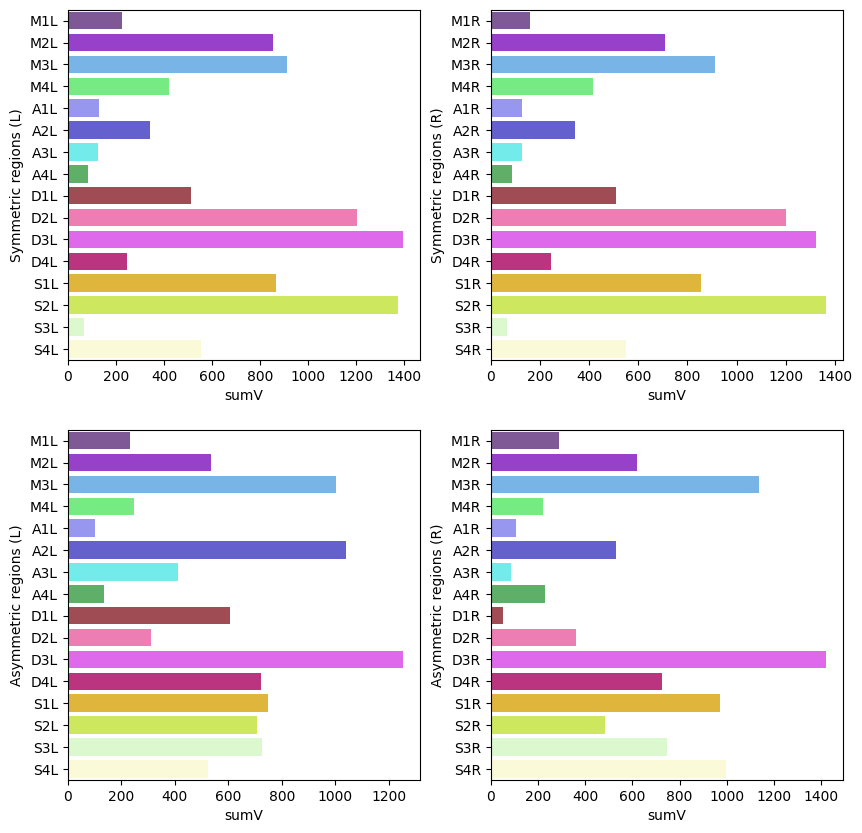

In [4]:
# Plot sizes for symmetric and asymmetric version in voxels
sz.make_size_subplot(prob_sym_group, prob_asym_group, labels, cmap, wta=True)


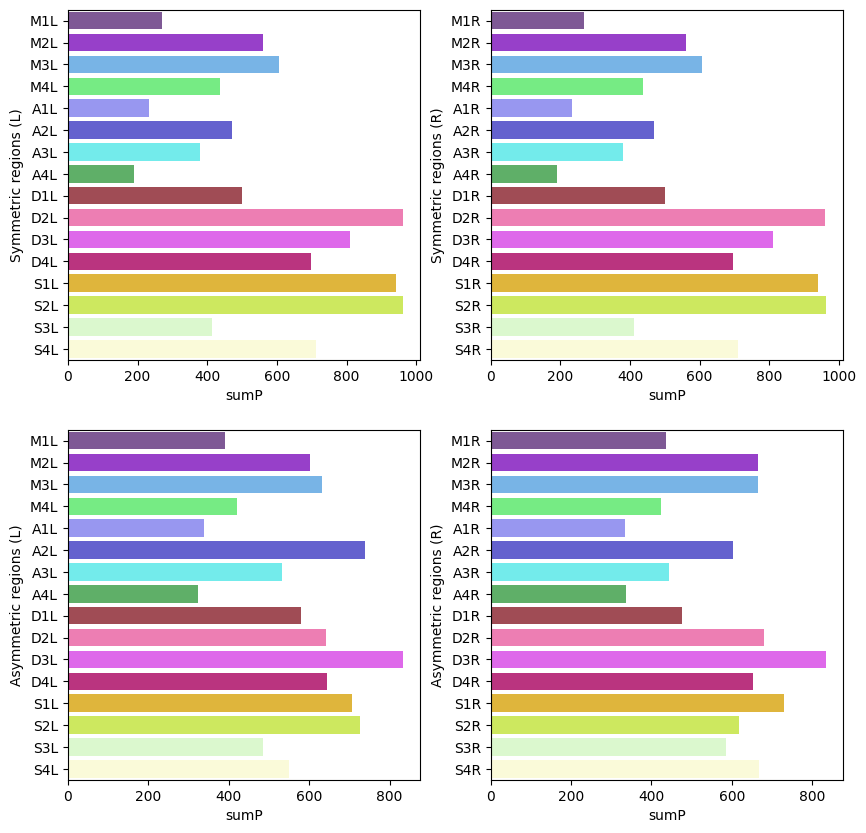

In [5]:
# Plot sizes for symmetric and asymmetric version in probabilities
sz.make_size_subplot(prob_sym_group, prob_asym_group, labels, cmap, wta=False)

## Left-right size comparison for asymmetric atlas version

In [6]:
# Construct dataframes
df = sz.make_df(sym_sumP, sym_sumV, asym_sumP, asym_sumV, labels)

# Make dataframe wide
df_wide = df.pivot_table(index=['subject', 'region', 'side', 'domain'],
                        columns=['symmetry'],
                        values=['voxels', 'prob'],
                        aggfunc='first').reset_index()
df_wide.columns = ['_'.join(col).strip() if col[1] != '' else col[0] for col in df_wide.columns.values]


df_wide['subject_num'] = df_wide['subject'].str[-1].astype(int)

# Calculate voxel difference and voxel change
df_change = df[['subject', 'region', 'cnum', 'side', 'domain']][df.symmetry == 'sym']
df_change['voxel_diff'] = (df_wide.voxels_asym.values - df_wide.voxels_sym.values)
df_change['voxel_change'] = (df_wide.voxels_asym.values - df_wide.voxels_sym.values) \
    / df_wide.voxels_sym.values

df_change[df_change['voxel_diff'] == np.inf] = np.nan
df_change[df_change['voxel_change'] == np.inf] = np.nan

domains = ['M', 'A', 'D', 'S']


/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_14746/1854769598.py:17: RuntimeWarning: divide by zero encountered in divide
  df_change['voxel_change'] = (df_wide.voxels_asym.values - df_wide.voxels_sym.values) \
/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_14746/1854769598.py:17: RuntimeWarning: invalid value encountered in divide
  df_change['voxel_change'] = (df_wide.voxels_asym.values - df_wide.voxels_sym.values) \


In [10]:
# --- Prepare dataframe for plotting left-right size comparison for asymmetric atlas version  ---
# Make left and right into columns 
df_wide['reg'] = df_wide['region'].str[:-1]
df_wider = df_wide.pivot_table(index=['subject', 'reg',  'domain'],
                        columns=['side'],
                        values = ['prob_sym', 'prob_asym', 'voxels_sym', 'voxels_asym'],
                        aggfunc='first').reset_index()
df_wider.columns = ['_'.join(col).strip() if col[1] != '' else col[0] for col in df_wider.columns.values]

# Calculate standard error and mean, then plot bar plot
df_diff = df_wider[['reg', 'subject', 'domain']]
df_diff['voxel_diff'] = (df_wider.voxels_asym_R.values - df_wider.voxels_asym_L.values) 
df_diff['prob_diff'] = (df_wider.prob_asym_R.values - df_wider.prob_asym_L.values) 
df_diff_barplot = df_diff[['reg', 'voxel_diff', 'prob_diff']].groupby(['reg']).mean().reset_index()
df_diff_barplot['voxels_diff_sem'] = df_diff[['reg', 'voxel_diff']].groupby(['reg']).sem().reset_index()['voxel_diff']
df_diff_barplot['prob_diff_sem'] = df_diff[['reg', 'prob_diff']].groupby(['reg']).sem().reset_index()['prob_diff']


/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_14746/3399133547.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diff['voxel_diff'] = (df_wider.voxels_asym_R.values - df_wider.voxels_asym_L.values)
/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_14746/3399133547.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diff['prob_diff'] = (df_wider.prob_asym_R.values - df_wider.prob_asym_L.values)


### Plot

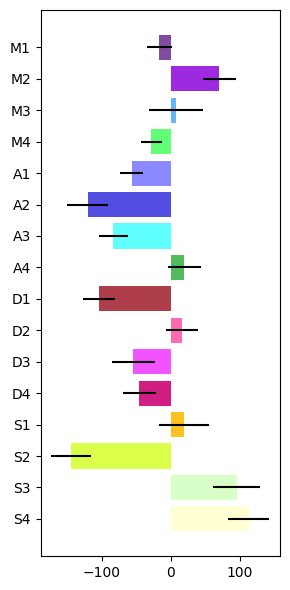

In [6]:
# Plot the horizontal bar charts
fig, ax = plt.subplots(figsize=(3, 6))

# sort df_diff_barplot by domain and region number
df_diff_barplot['domain_num'] = df_diff_barplot['reg'].apply(lambda x: domains.index(x[0]))
df_diff_barplot['region_num'] = df_diff_barplot['reg'].apply(lambda x: int(x[1]))
df_diff_barplot = df_diff_barplot.sort_values(by=['domain_num', 'region_num'])

# Plot the horizontal bar charts
pal_one_hem = {r: ListedColormap(cmap)(i+1) for i, r in enumerate(df_diff_barplot.reg)}
plt.barh(df_diff_barplot.reg, df_diff_barplot.voxel_diff, xerr=df_diff_barplot.voxels_diff_sem, color=pal_one_hem.values())
ax.invert_yaxis()
# Adjust layout
plt.tight_layout()
plt.savefig(ut.figure_dir + f"parcel_sizes_asym_hem_indiv_horzbarplot.pdf")


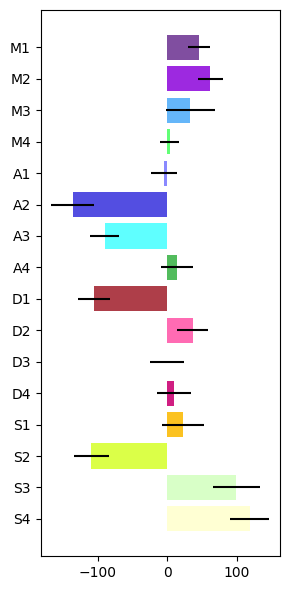

In [11]:
# Plot the horizontal bar charts
fig, ax = plt.subplots(figsize=(3, 6))

# sort df_diff_barplot by domain and region number
df_diff_barplot['domain_num'] = df_diff_barplot['reg'].apply(lambda x: domains.index(x[0]))
df_diff_barplot['region_num'] = df_diff_barplot['reg'].apply(lambda x: int(x[1]))
df_diff_barplot = df_diff_barplot.sort_values(by=['domain_num', 'region_num'])

# Plot the horizontal bar charts
pal_one_hem = {r: ListedColormap(cmap)(i+1) for i, r in enumerate(df_diff_barplot.reg)}
plt.barh(df_diff_barplot.reg, df_diff_barplot.prob_diff, xerr=df_diff_barplot.prob_diff_sem, color=pal_one_hem.values())
ax.invert_yaxis()
# Adjust layout
plt.tight_layout()
plt.savefig(ut.figure_dir + f"parcel_sizes_asym_hem_indiv_prob_horzbarplot.pdf")


## Size comparison between symmetric and asymmetric atlas version

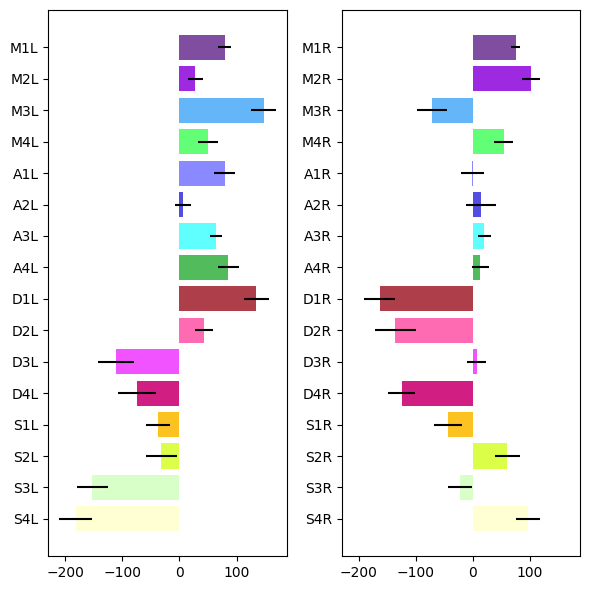

In [7]:
# --- Size comparison of left and right ---
# Calculate standard error and mean, then plot bar plot
df_barplot = df_change[['region', 'voxel_diff', 'voxel_change']].groupby(['region']).mean().reset_index()
df_barplot['side'] = df_barplot['region'].str[-1]
df_barplot['domain'] = df_barplot['region'].str[0]
df_barplot['change_voxels_sem'] = df_change[['region', 'voxel_diff']].groupby(['region']).sem().reset_index()['voxel_diff']
df_barplot['change_voxels_norm_sem'] = df_change[['region', 'voxel_change']].groupby(['region']).sem().reset_index()['voxel_change']
# Sort regions by domain and number
df_barplot['domain_num'] = df_barplot['domain'].apply(lambda x: domains.index(x))
df_barplot['region_num'] = df_barplot['region'].apply(lambda x: int(x[1]))
df_barplot = df_barplot.sort_values(by=['domain_num', 'region_num'])


df_left= df_barplot[df_barplot.side == 'L']
df_right= df_barplot[df_barplot.side == 'R']
pal_one_hem = {r: ListedColormap(cmap)(i+1) for i, r in enumerate(df_left.region)}

# Plot the horizontal bar charts
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(6, 6))
# Plot the horizontal bar charts
axes[0].barh(df_left.region, df_left.voxel_diff, xerr=df_left.change_voxels_sem, color=pal_one_hem.values())
axes[1].barh(df_right.region, df_right.voxel_diff, xerr=df_right.change_voxels_sem, color=pal_one_hem.values())
for ax in axes:
    ax.invert_yaxis()
# Adjust layout
plt.tight_layout()
plt.savefig(ut.figure_dir + f"parcel_sizes_sym_vs_asym_indiv_horzbarplot.pdf")

